### [GD-2] ResNet Ablation Study

##### 0. 라이브러리

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.9.2
1.21.6


In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### 1. 데이터 준비

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.
totalSet, ds_info = tfds.load('cats_vs_dogs', with_info=True, split='train', shuffle_files=True)
ds_size = 1000 # len(totalSet)
train_size = int(ds_size * 0.8)
test_size = ds_size - train_size
ds_train = totalSet.take(train_size)
ds_test = totalSet.skip(train_size).take(test_size)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteMPGRV0/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


##### 2. 데이터 확인

In [4]:
print(ds_info.features['label'].catalog_documentation())

[CatalogFeatureDocumentation(name='', cls_name='ClassLabel', description=None, value_range=None, tensor_info=TensorInfo(shape=(), dtype=tf.int64))]


In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

!ls ~/.keras/*


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
/root/.keras/keras.json


In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(len(ds_train), len(ds_test))

800 200


In [7]:
ds_info.features["label"].num_classes

2

In [8]:
ds_info.features["label"].names

['cat', 'dog']

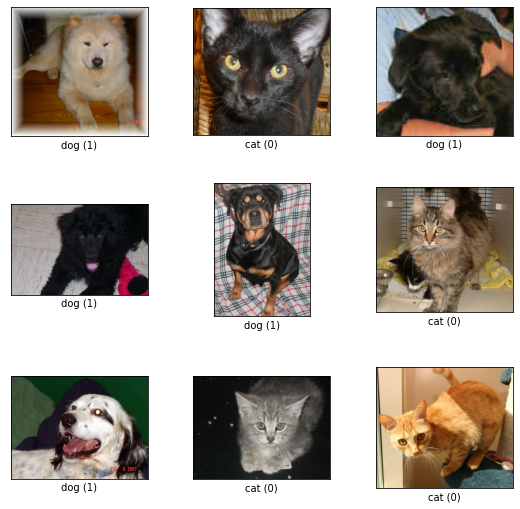

In [9]:
fig = tfds.show_examples(ds_train, ds_info)

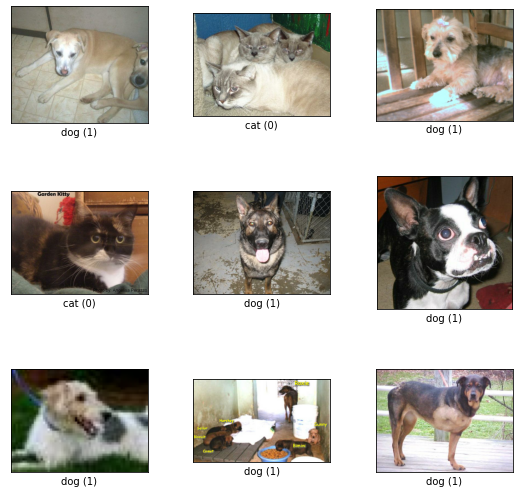

In [10]:
fig = tfds.show_examples(ds_test, ds_info)

##### 3. 모델 만들기.

In [11]:
def shortcut_connection(input, residual, block_num, small_block):
    
    stride = (1, 1)
    
    if 0 == small_block and 2 != block_num:
        stride = (2, 2)
    
    # channel이 달라지면 1x1 conv를 실행하여 입력 channel크기를 residual크기에 맞춘다.
    if input.get_shape()[3] != residual.get_shape()[3]:
        input = keras.layers.Conv2D(
            filters=residual.get_shape()[3],
            kernel_size=(1,1),
            strides=stride,
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}.{small_block}',
        )(input)

    return tf.keras.layers.Add(name=f'add{block_num}.{small_block}')([input, residual])


In [12]:
def resnet_basic_block(input, block_num, idx, plain, chnnel_cnt):
    '''
    rn34 : 3x3 conv - 3x3 conv
    source를 참고하여 
    '''
    x = input
    
    for loop in range(2):
        
        # 중간 block은 feature map을 입력받으므로 bn, activation을 먼저 한다.
        if 0 != loop or 2 != block_num:
            x = keras.layers.BatchNormalization(name=f'bn{block_num}.{idx}.{loop}')(x)
            x = tf.keras.layers.Activation('relu', name=f'relu{block_num}.{idx}.{loop}')(x)

        # block이 바뀌면 stride로 크기를 줄여줌.
        stride = (1,1)
        if 0 == idx and 0 == loop and 2 != block_num:
            stride = (2,2)

        x = keras.layers.Conv2D(
                filters=chnnel_cnt,
                kernel_size=(3,3),
                strides=stride,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'conv{block_num}.{idx}.{loop}',
                # kernel_regularizer=l2(1e-4),
            )(x)
    
    if plain:
        return x
    
    else:
        # resnet은 conv후 feature map에 대하여 short_connection하여 전달함.
        # bn, activation은 다음 block 입력시 처리한다.
        return shortcut_connection(input, x, block_num, idx)


In [13]:
def resnet_bottle_block(input, block_num, idx, plain, chnnel_cnt):
    '''
    rn50: 1x1 conv - 3x3 conv - 1x1 conv
    '''
    x = input
    
    for loop in range(3):
        
        # 중간 block은 feature map을 입력받으므로 bn, activation을 먼저 한다.
        if 0 != loop or 2 != block_num:
            x = keras.layers.BatchNormalization(name=f'bn{block_num}.{idx}.{loop}')(x)
            x = tf.keras.layers.Activation('relu', name=f'relu{block_num}.{idx}.{loop}')(x)

        # block이 바뀌면 stride로 크기를 줄여줌.
        stride = (1,1)
        if 0 == idx and 0 == loop and 2 != block_num:
            stride = (2,2)

        channels = chnnel_cnt
        krn_size = (1,1)
        if loop == 2:
            channels = chnnel_cnt*4
        if loop == 1:
            krn_size = (3,3)
        
        x = keras.layers.Conv2D(
            filters=channels,
            kernel_size=krn_size,
            strides=stride,
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}.{idx}.{loop}',
            # kernel_regularizer=l2(1e-4),
        )(x)
    
    if plain:
        return x
    
    else:
        # resnet은 conv후 feature map에 대하여 short_connection하여 전달함.
        # bn, activation은 다음 block 입력시 처리한다.
        return shortcut_connection(input, x, block_num, idx)

In [14]:
# function for building ResNet Block

def build_resnet_block(input, channels, small_blocks, block_num, plain, is_50):
    # 입력 레이어
    x = input

    for idx in range(small_blocks):
        
        if is_50:
            x = resnet_bottle_block(x, block_num, idx, plain, channels)
        else:    
            x = resnet_basic_block(x, block_num, idx, plain, channels)

    return x

In [15]:
def build_resnet(input_shape=(224, 224,3), plain=False, is_50=False):

    input = keras.layers.Input(shape=input_shape, name="input_layer")   # 입력 레이어 생성

    x = keras.layers.Conv2D(
                        filters=64,
                        kernel_size=(7,7),
                        strides=(2,2),
                        activation=None,
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'conv1',
                    )(input)
    
    x = keras.layers.BatchNormalization(name='bn1')(x)
    x = tf.keras.layers.Activation('relu', name='relu1')(x)
    x = keras.layers.MaxPooling2D(
                        pool_size=(3, 3),
                        strides=(2,2),
                        padding='same',
                        name=f'max_pooling'
                    )(x)

    x = build_resnet_block(x,  64, 3, 2, plain, is_50)
    x = build_resnet_block(x, 128, 4, 3, plain, is_50)
    x = build_resnet_block(x, 256, 6, 4, plain, is_50)
    x = build_resnet_block(x, 512, 3, 5, plain, is_50)

    x = keras.layers.AveragePooling2D(pool_size=1, strides=(1,1), name=f'avg_pool')(x)
    x = keras.layers.Flatten(name='flatten')(x)
    output = keras.layers.Dense(10, name='fc', activation='softmax')(x)
    
    name = 'ResNet'
    if plain:
        name += '_plain'
        
    if is_50:
        name += '_50'
    else:
        name += '_34'

    return keras.Model(inputs=input, outputs=output, name=name)


##### 4. 모델 생성.

In [16]:
# ResNet 34 생성.
resnet34 = build_resnet((224, 224, 3), plain=False, is_50=False)
resnet34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 bn1 (BatchNormalization)       (None, 112, 112, 64  256         ['conv1[0][0]']                  
                                )                                                         

In [17]:
# Plain 34 생성.
plain34 = build_resnet((224, 224, 3), plain=True, is_50=False)
plain34.summary()

Model: "ResNet_plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 64)      9472      
                                                                 
 bn1 (BatchNormalization)    (None, 112, 112, 64)      256       
                                                                 
 relu1 (Activation)          (None, 112, 112, 64)      0         
                                                                 
 max_pooling (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 conv2.0.0 (Conv2D)          (None, 56, 56, 64)        36928     
                                                                 
 bn2.0.1 (BatchNormalization  (None, 56, 56, 64)   

In [18]:
# Plain 50 생성.
plain50 = build_resnet((224, 224, 3), plain=True, is_50=True)
plain50.summary()

Model: "ResNet_plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 64)      9472      
                                                                 
 bn1 (BatchNormalization)    (None, 112, 112, 64)      256       
                                                                 
 relu1 (Activation)          (None, 112, 112, 64)      0         
                                                                 
 max_pooling (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 conv2.0.0 (Conv2D)          (None, 56, 56, 64)        4160      
                                                                 
 bn2.0.1 (BatchNormalization  (None, 56, 56, 64)   

In [19]:
# ResNet 50 생성.
resnet50 = build_resnet((224, 224, 3), plain=False, is_50=True)
resnet50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 bn1 (BatchNormalization)       (None, 112, 112, 64  256         ['conv1[0][0]']                  
                                )                                                         

##### 5. 데이터셋 준비

In [20]:
BATCH_SIZE = 8
EPOCH = 15

In [21]:
def normalize_and_resize_img(data, w, h):
    """Normalizes images: `uint8` -> `float32`."""
    image = data['image']
    label = data['label']
    image = tf.image.resize(image, [w, h])
    return tf.cast(image, tf.float32) / 255., label

In [22]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, w=32, h=32):
    images = []
    labels = []
    for data in ds:
        image, label = normalize_and_resize_img(data, w, h)
        images.append(image)
        labels.append(label)

    dds = tf.data.Dataset.from_tensor_slices((images, labels))
    # ds = ds.map(
    #     normalize_and_resize_img, 
    #     num_parallel_calls=1
    # )
    dds = dds.batch(batch_size)
    if not is_test:
        dds = dds.repeat()
        dds = dds.shuffle(200)
    dds = dds.prefetch(tf.data.experimental.AUTOTUNE)
    return dds

In [23]:
dds_train32 = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, is_test=False, w=32, h=32)
dds_test32 = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE, is_test=True, w=32, h=32)

dds_train224 = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, is_test=False, w=224, h=224)
dds_test224 = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE, is_test=True, w=224, h=224)

##### 6. 학습 및 테스트

In [24]:
def compile_fit(model, ds_tr, ds_te):
    model.compile(
                    loss='sparse_categorical_crossentropy',
                    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
                    metrics=['accuracy'],
                )

    history = model.fit(
                    ds_tr,
                    steps_per_epoch=int(train_size/BATCH_SIZE),
                    validation_steps=int(test_size/BATCH_SIZE),
                    epochs=EPOCH,
                    validation_data=ds_te,
                    verbose=1,
                    use_multiprocessing=True,
                )
    return history.history

In [25]:
import matplotlib.pyplot as plt

def plot_history(historys, titles):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
    for idx, history in enumerate(historys):
        plt.plot(history['loss'], colors[idx])
    plt.title('Model training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(titles, loc='upper left')
    plt.show()

In [26]:
hist_plain34 = compile_fit(plain34, dds_train224, dds_test224)
hist_resnet34 = compile_fit(resnet34, dds_train224, dds_test224)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/15
100/100 [==============================] - 18s 37ms/step - loss: 1.1390 - accuracy: 0.5075 - val_loss: 1.0561 - val_accuracy: 0.4750
Epoch 2/15
100/100 [==============================] - 3s 30ms/step - loss: 1.0381 - accuracy: 0.5100 - val_loss: 0.8139 - val_accuracy: 0.4900
Epoch 3/15
100/100 [==============================] - 3s 30ms/step - loss: 0.9409 - accuracy: 0.5387 - val_loss: 0.7510 - val_accuracy: 0.4950
Epoch 4/15
100/100 [==============================] - 3s 30ms/step - loss: 0.8675 - accuracy: 0.5688 - val_loss: 0.8345 - val_accuracy: 0.4950
Epoch 5/15
100/100 [==============================] - 3s 32ms/step - loss: 0.9387 - accuracy: 0.5663 - val_loss: 1.0412 - val_accuracy: 0.4750
Epoch 6/15
100/100 [==============================] - 3s 30ms/step - loss: 0.8462 - accuracy: 0.5788 - val_loss: 1.0729 - val_accuracy: 0.5700
Epoch 7/15
100/100 [==============================] - 3s 30ms/step - loss: 0.8103 - accuracy: 0.5950 - val_loss: 0.9267 - val_accuracy: 0.570

In [27]:
hist_plain50 = compile_fit(plain50, dds_train224, dds_test224)
hist_resnet50 = compile_fit(resnet50, dds_train224, dds_test224)

Epoch 1/15
100/100 [==============================] - 14s 53ms/step - loss: 1.1737 - accuracy: 0.4975 - val_loss: 0.8825 - val_accuracy: 0.4700
Epoch 2/15
100/100 [==============================] - 4s 44ms/step - loss: 1.0478 - accuracy: 0.5238 - val_loss: 0.7571 - val_accuracy: 0.4550
Epoch 3/15
100/100 [==============================] - 4s 44ms/step - loss: 1.0718 - accuracy: 0.5125 - val_loss: 1.0542 - val_accuracy: 0.4800
Epoch 4/15
100/100 [==============================] - 4s 44ms/step - loss: 0.9959 - accuracy: 0.5487 - val_loss: 0.8951 - val_accuracy: 0.5200
Epoch 5/15
100/100 [==============================] - 4s 43ms/step - loss: 1.0316 - accuracy: 0.5412 - val_loss: 2.5721 - val_accuracy: 0.5200
Epoch 6/15
100/100 [==============================] - 4s 44ms/step - loss: 0.9714 - accuracy: 0.5638 - val_loss: 2.0743 - val_accuracy: 0.4800
Epoch 7/15
100/100 [==============================] - 4s 44ms/step - loss: 1.0060 - accuracy: 0.5400 - val_loss: 2.4895 - val_accuracy: 0.480

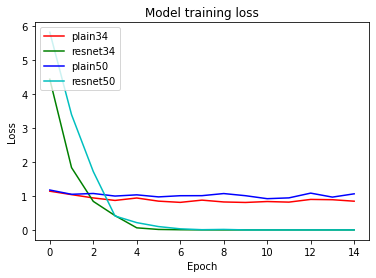

In [28]:
plot_history([hist_plain34, hist_resnet34, hist_plain50, hist_resnet50], ['plain34', 'resnet34', 'plain50', 'resnet50'])

##### 7. 회고  

- ResNet을 직접 구현해보는 시간이었다.  
- DataSet 만드는 것부터 삽질의 연속이었다.;;  
- 논문만 보고는 activation, Batch norm등을 올바로 구현하기가 어려워 ResNet소스를 참조했다.  
- plain모델은 학습이 거의 안된것 같다. 반면 resnet모델들은 loss가 떨어지는게 잘 보였다.  너무 떨어져서 이상한것 같다.;;  
- 리소스 부족으로 계속 죽어서 dataset을 만들때 분할해서 생성해야할 것 같다.  